In [399]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot

from datetime import date

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import math

import warnings

# Suppress warnings
warnings.filterwarnings("ignore")


## 1.1. Data collection

In [400]:
file_path = 'data/vietnam_macro_economic_by_month.csv'
data = pd.read_csv(file_path)
data.head()

,Thời gian,FDI,FDI đăng kí (lũy kế năm),FDI giải ngân (lũy kế năm),Thương mại (lũy kế năm),Xuất khẩu (lũy kế năm),Nhập khẩu (lũy kế năm),Cung tiền & tín dụng,Tăng trưởng tín dụng,Nông nghiệp,...,Chi thường xuyên,Chỉ số giá,Lạm phát cơ bản,Lạm phát,Thực phẩm,Nhà ở và VLXD,Y tế,Vận tải,Chỉ số PMI,Tăng trưởng GDP thực tế
0,-,-,% YoY,% YoY,-,% YoY,% YoY,-,% YoY,% YoY,...,% YoY,-,% YoY,% YoY,% YoY,% YoY,% YoY,% YoY,-,% YoY
1,T1 2017,-,19,6.3,-,6,3.2,-,19.5,17.7,...,NaN,-,1.9,5.2,2.4,3.5,79.4,5,51.9,5.2
2,T2 2017,-,21.5,3.3,-,16.5,23.5,-,19.6,17.5,...,NaN,-,1.5,5,-0.3,4.8,79.8,10,54.2,5.2
3,T3 2017,-,91.5,3.4,-,15.7,25.4,-,21.6,17.9,...,NaN,-,1.6,4.7,-0.9,5.3,48.7,14.6,54.6,5.2
4,T4 2017,-,53.9,3.2,-,17.4,24.8,-,20.6,17.8,...,NaN,-,1.5,4.3,-1.7,4.3,63.6,11.1,54.1,6.4


## 1.2. Data Preprocessing

### 1.2.1. Clean columns

In [401]:
data.columns

Index(['Thời gian', 'FDI', 'FDI đăng kí (lũy kế năm)',
       'FDI giải ngân (lũy kế năm)', 'Thương mại (lũy kế năm)',
       'Xuất khẩu  (lũy kế năm)', 'Nhập khẩu  (lũy kế năm)',
       'Cung tiền & tín dụng', 'Tăng trưởng tín dụng', 'Nông nghiệp',
       'Thương mại', 'Công nghiệp', 'Xây dựng', 'Cung tiền M2', 'Tài khóa',
       'Tổng thu', 'Nội địa', 'Tổng chi', 'Chi đầu tư phát triển',
       'Chi thường xuyên', 'Chỉ số giá', 'Lạm phát cơ bản', 'Lạm phát',
       'Thực phẩm', 'Nhà ở và VLXD', 'Y tế', 'Vận tải', 'Chỉ số PMI',
       'Tăng trưởng GDP thực tế'],
      dtype='object')

In [402]:
columns = ['Thoi_gian', 'FDI', 'FDI_dang_ki',
       'FDI_giai_ngan', 'Thuong_mai_luy_ke_nam',
       'Xuat_khau_luy_ke_nam', 'Nhap_khau_luy_ke_nam',
       'Cung_tien_va_tin_dung', 'Tang_truong_tin_dung', 'Nong_nghiep',
       'Thuong_mai', 'Cong_nghiep', 'Xay_dung', 'Cung_tien_M2', 'Tai_khoa',
       'Tong_thu', 'Noi_dia', 'Tong_chi', 'Chi_dau_tu_phat_trien',
       'Chi_thuong_xuyen', 'Chi_so_gia', 'Lam_phat_co_ban', 'Lam_phat',
       'Thuc_pham', 'Nha_o_va_VLXD', 'Y_te', 'Van_tai', 'Chi_so_PMI',
       'Tang_truong_GDP_thuc_te']

data.columns = columns

print("Column names after cleaning:", data.columns)

Column names after cleaning: Index(['Thoi_gian', 'FDI', 'FDI_dang_ki', 'FDI_giai_ngan',
       'Thuong_mai_luy_ke_nam', 'Xuat_khau_luy_ke_nam', 'Nhap_khau_luy_ke_nam',
       'Cung_tien_va_tin_dung', 'Tang_truong_tin_dung', 'Nong_nghiep',
       'Thuong_mai', 'Cong_nghiep', 'Xay_dung', 'Cung_tien_M2', 'Tai_khoa',
       'Tong_thu', 'Noi_dia', 'Tong_chi', 'Chi_dau_tu_phat_trien',
       'Chi_thuong_xuyen', 'Chi_so_gia', 'Lam_phat_co_ban', 'Lam_phat',
       'Thuc_pham', 'Nha_o_va_VLXD', 'Y_te', 'Van_tai', 'Chi_so_PMI',
       'Tang_truong_GDP_thuc_te'],
      dtype='object')


In [403]:
selected_columns = ['Thoi_gian', 'FDI_dang_ki', 'Xuat_khau_luy_ke_nam', 'Nhap_khau_luy_ke_nam', 'Tang_truong_tin_dung', 'Cung_tien_M2', 'Lam_phat', 'Tang_truong_GDP_thuc_te']
data = data[selected_columns]

# Drop hàng thứ 2 (hàng chứa thông tin về đơn vị)
data = data.drop(0)

data.head()
data.shape

(84, 8)

### 1.2.2. Convert date format

In [404]:
def convert_date(date_str):
    month_map = {
        'T1': '01', 'T2': '02', 'T3': '03', 'T4': '04', 'T5': '05',
        'T6': '06', 'T7': '07', 'T8': '08', 'T9': '09', 'T10': '10',
        'T11': '11', 'T12': '12'
    }
    month, year = date_str.split()
    month = month_map[month]
    return pd.to_datetime(f'{year}-{month}-01')


time_column = 'Thoi_gian'
data[time_column] = data[time_column].apply(convert_date)

data[time_column] = pd.to_datetime(data[time_column])
data.set_index(time_column, inplace=True)

data.head()

,FDI_dang_ki,Xuat_khau_luy_ke_nam,Nhap_khau_luy_ke_nam,Tang_truong_tin_dung,Cung_tien_M2,Lam_phat,Tang_truong_GDP_thuc_te
Thoi_gian,,,,,,,
2017-01-01,19,6,3.2,19.5,19.7,5.2,5.2
2017-02-01,21.5,16.5,23.5,19.6,18.1,5,5.2
2017-03-01,91.5,15.7,25.4,21.6,17.7,4.7,5.2
2017-04-01,53.9,17.4,24.8,20.6,17,4.3,6.4
2017-05-01,19.4,19,25.3,22,16.2,3.2,6.4


### 1.2.3. Handle missing value

In [405]:
data.isna().sum()

FDI_dang_ki                0
Xuat_khau_luy_ke_nam       5
Nhap_khau_luy_ke_nam       2
Tang_truong_tin_dung       0
Cung_tien_M2               0
Lam_phat                   0
Tang_truong_GDP_thuc_te    0
dtype: int64

In [406]:
xuat_khau = 'Xuat_khau_luy_ke_nam'
nhap_khau = 'Nhap_khau_luy_ke_nam'

data[xuat_khau] = data[xuat_khau].replace({None: np.nan, '': np.nan})
data[nhap_khau] = data[nhap_khau].replace({None: np.nan, '': np.nan})

data[xuat_khau] = pd.to_numeric(data[xuat_khau], errors='coerce')
data[nhap_khau] = pd.to_numeric(data[nhap_khau], errors='coerce')

# xử lí những giá trị null trong cột xuất khẩu và nhập khẩu bằng nội suy tuyến tính
data[xuat_khau] = data[xuat_khau].interpolate(method='linear')
data[nhap_khau] = data[nhap_khau].interpolate(method='linear')

missing_values = data.isna().sum()
missing_values[missing_values > 0]

data = data.astype(float)

### 1.2.2. Stationarity

#### Plot time series and check for trends or seasonality with mean and varience

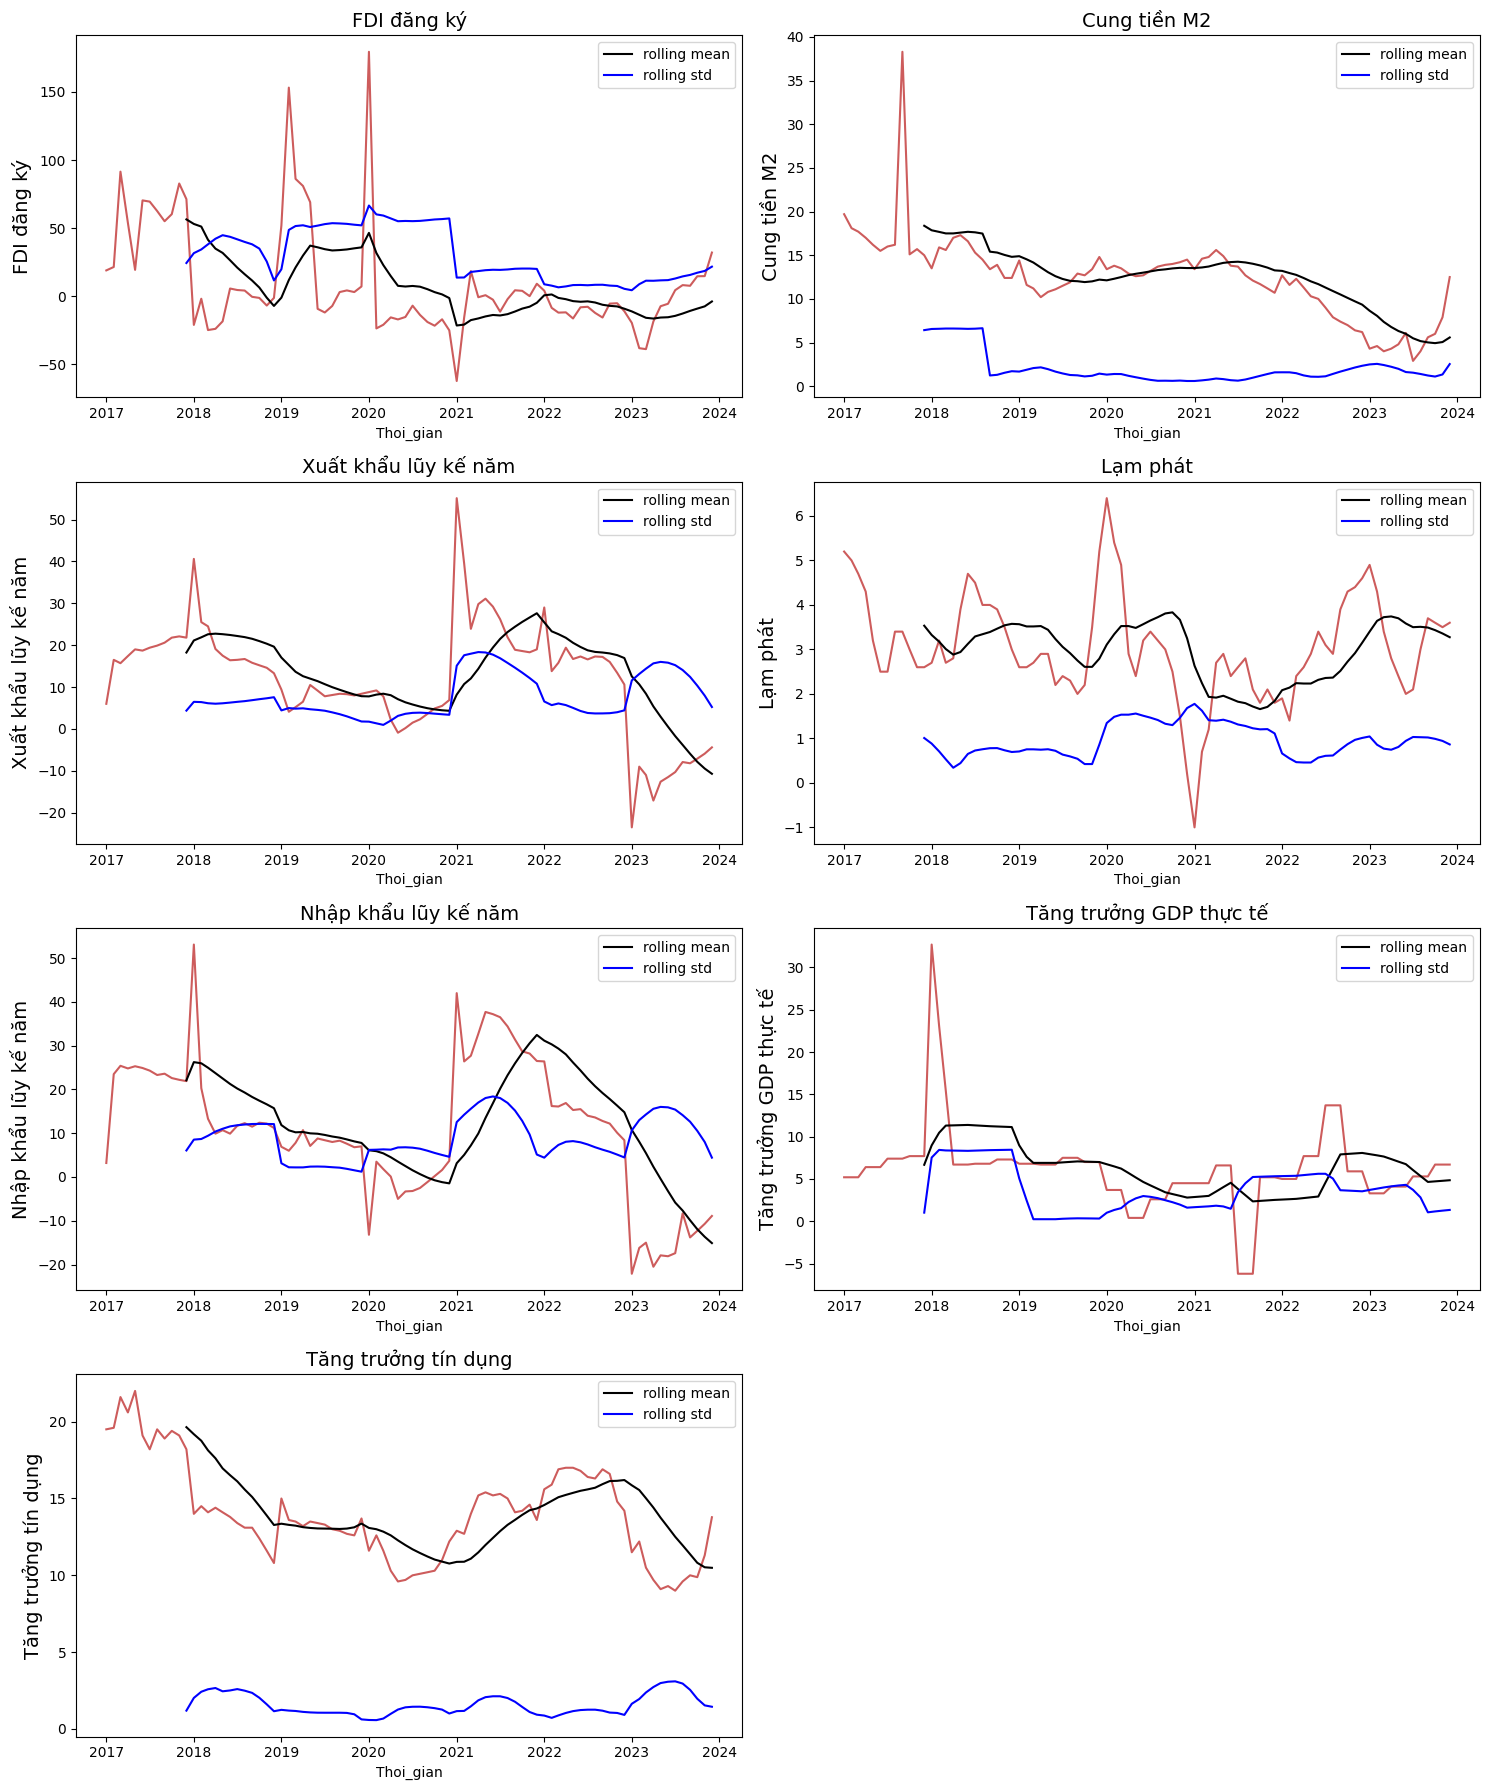

In [407]:
def plot_time_series(ax, x, y, rolling_window, title, ylabel, color='indianred'):
    sns.lineplot(x=x, y=y, ax=ax, color=color)
    sns.lineplot(x=x, y=y.rolling(rolling_window).mean(), ax=ax, color='black', label='rolling mean')
    sns.lineplot(x=x, y=y.rolling(rolling_window).std(), ax=ax, color='blue', label='rolling std')
    ax.set_title(title, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)

rolling_window = 12  # Đặt giá trị phù hợp với dữ liệu (12 tháng = 1 năm)
f, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 18))

plot_time_series(ax[0, 0], data.index, data.FDI_dang_ki, rolling_window, 'FDI đăng ký', 'FDI đăng ký')
plot_time_series(ax[1, 0], data.index, data.Xuat_khau_luy_ke_nam, rolling_window, 'Xuất khẩu lũy kế năm', 'Xuất khẩu lũy kế năm')
plot_time_series(ax[2, 0], data.index, data.Nhap_khau_luy_ke_nam, rolling_window, 'Nhập khẩu lũy kế năm', 'Nhập khẩu lũy kế năm')
plot_time_series(ax[3, 0], data.index, data.Tang_truong_tin_dung, rolling_window, 'Tăng trưởng tín dụng', 'Tăng trưởng tín dụng')
plot_time_series(ax[0, 1], data.index, data.Cung_tien_M2, rolling_window, 'Cung tiền M2', 'Cung tiền M2')
plot_time_series(ax[1, 1], data.index, data.Lam_phat, rolling_window, 'Lạm phát', 'Lạm phát')
plot_time_series(ax[2, 1], data.index, data.Tang_truong_GDP_thuc_te, rolling_window, 'Tăng trưởng GDP thực tế', 'Tăng trưởng GDP thực tế')

f.delaxes(ax[3, 1])  # Remove empty plot if exists

plt.tight_layout()
plt.show()


Chúng ta có thể thấy rằng tất cả các feature đều có phương sai trung bình và  hằng số thay đổi theo thời gian.  
Nếu như quan sát bằng những biểu đồ này, không cái nào trong số này có tính dừng.   

#### Augmented Dickey-Fuller (ADF) test

Forest Green: Strong evidence that the series is stationary (ADF statistic is less than the 1% critical value).     
Gold: Moderate evidence that the series is stationary (ADF statistic is less than the 5% critical value).   
Orange: Weak evidence that the series is stationary (ADF statistic is less than the 10% critical value).    
Indian Red: Evidence that the series is non-stationary. 

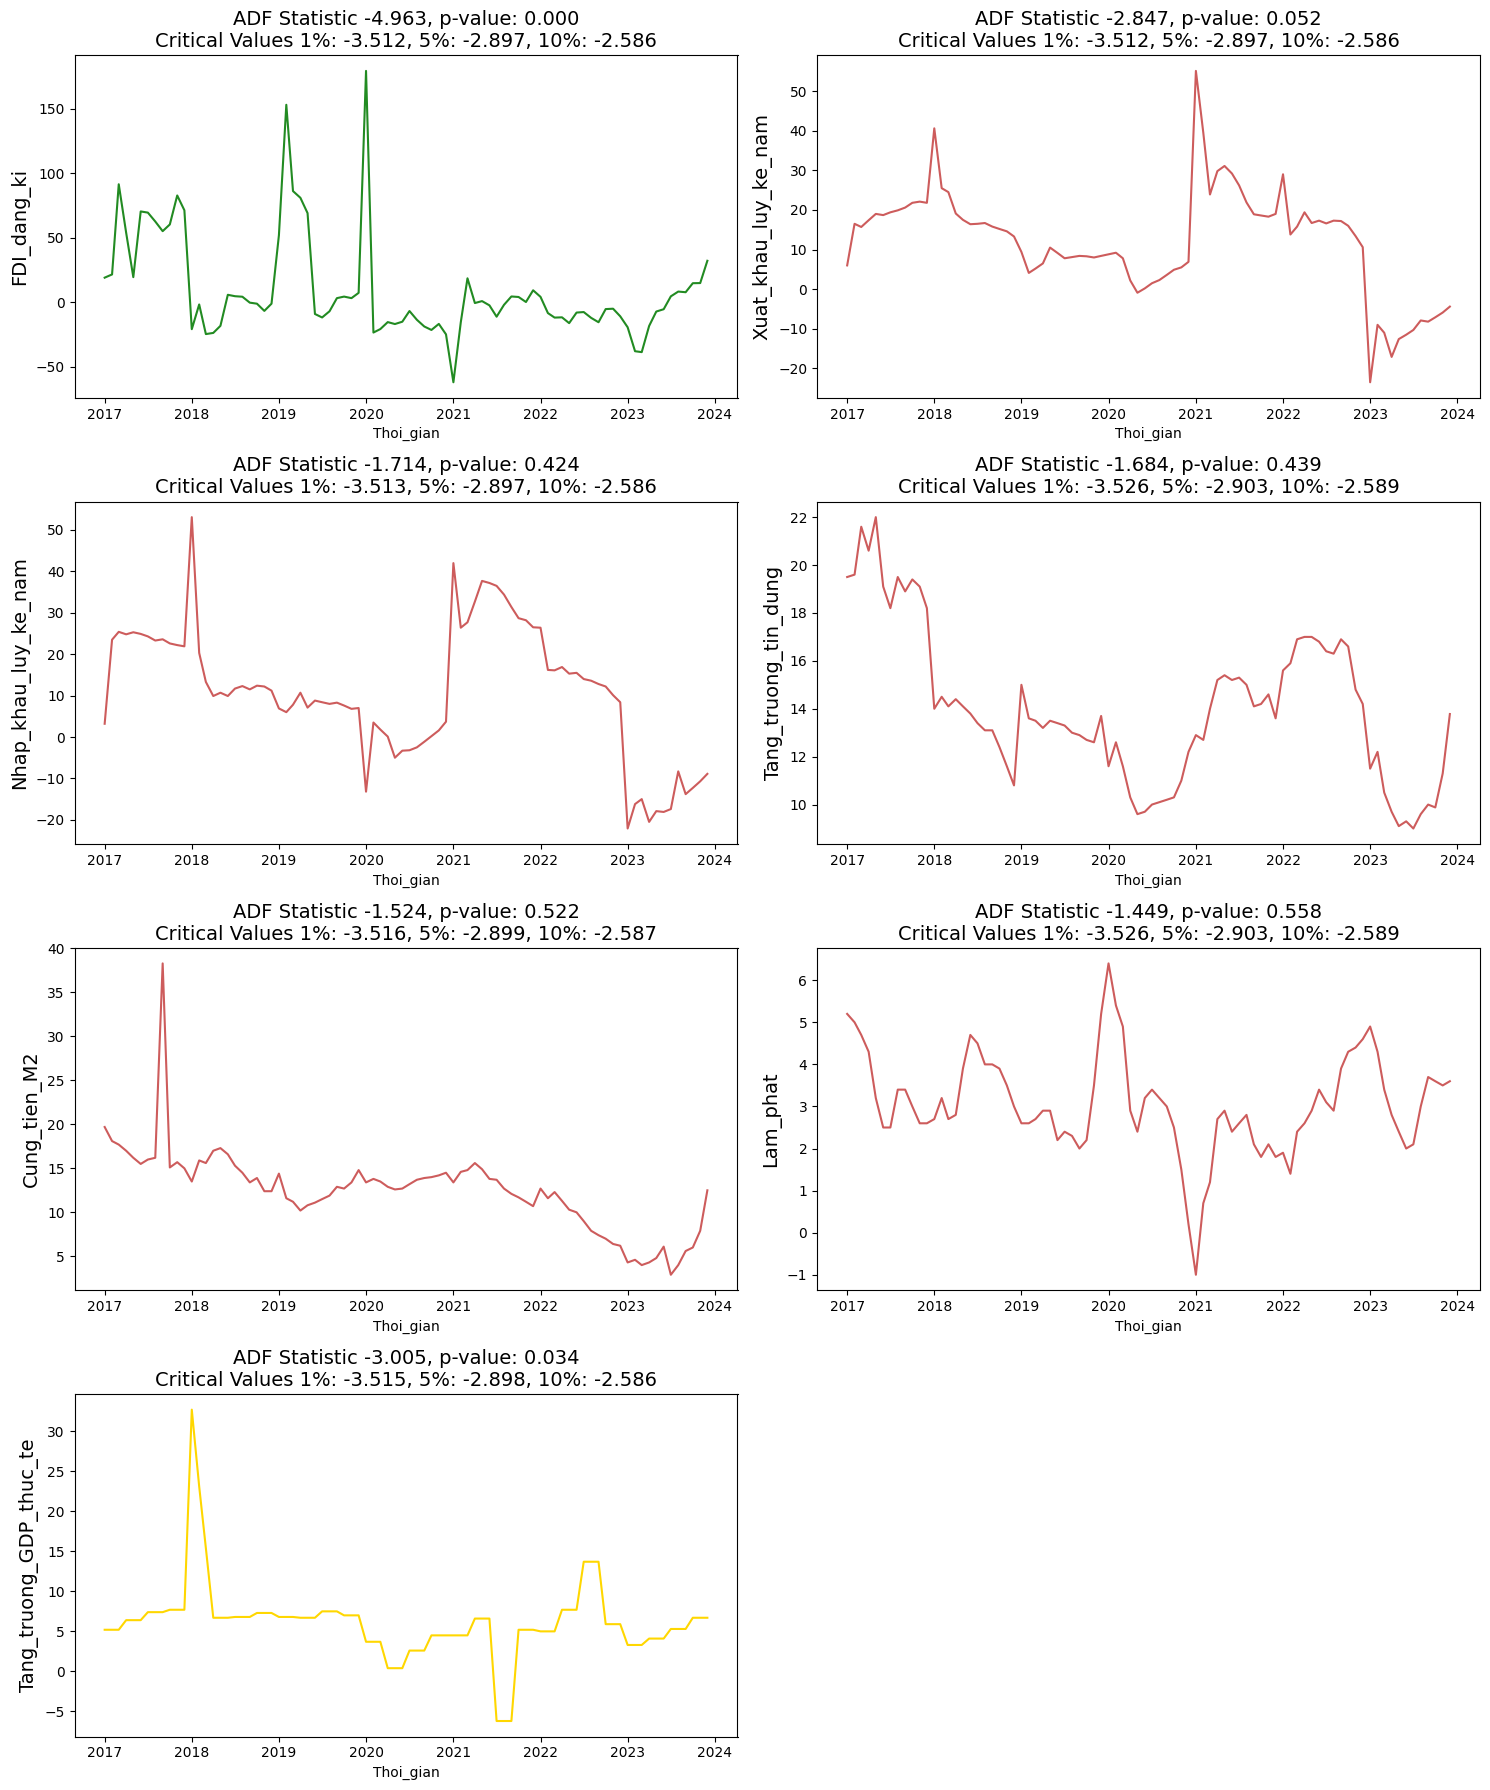

In [408]:
def visualize_adfuller_results(series, title, ax):
    result = adfuller(series) # check adf
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & (adf_stat < crit_val_1):
        linecolor = 'forestgreen'
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'gold'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'orange'
    else:
        linecolor = 'indianred'

    sns.lineplot(x=series.index, y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

f, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 18))

columns = ['FDI_dang_ki', 'Xuat_khau_luy_ke_nam', 'Nhap_khau_luy_ke_nam', 
           'Tang_truong_tin_dung', 'Cung_tien_M2', 'Lam_phat', 'Tang_truong_GDP_thuc_te']

for i, column in enumerate(columns):
    row = i // 2
    col = i % 2
    visualize_adfuller_results(data[column], column, ax[row, col])

# Remove empty subplots if has
if len(columns) % 2 != 0:
    f.delaxes(ax[len(columns) // 2, 1])

plt.tight_layout()
plt.show()


Chúng ta có thể thấy rằng ngoài 2 feature là FDI_dang_ki và Tang_truong_GDP thực tế thì không có feature nào có tính dừng

### 1.2.3. Transformation

#### Thực hiện transform cho cột lạm phát

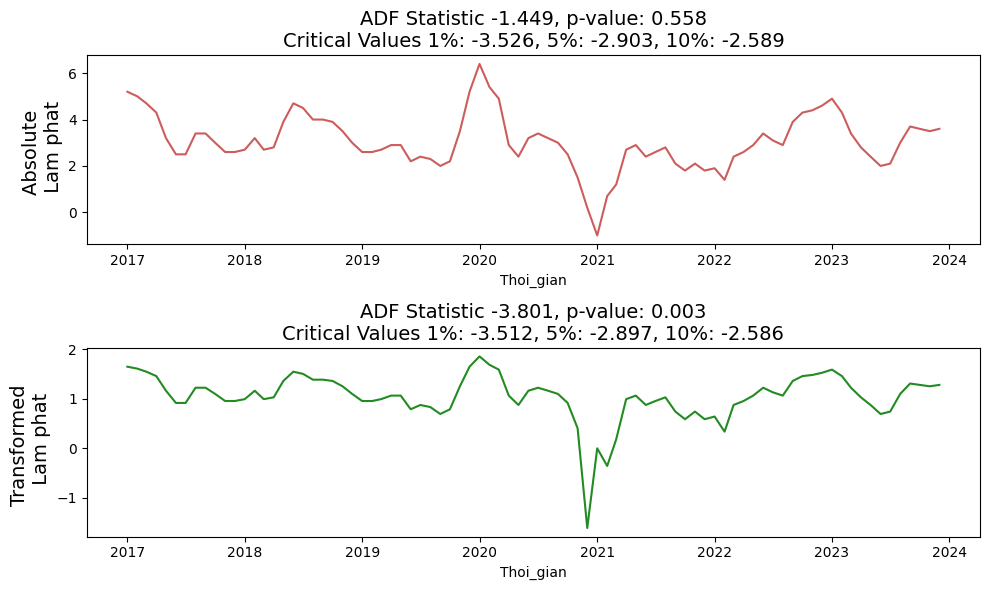

In [409]:
data['Lam_phat_transformed'] = np.log(abs(data.Lam_phat))

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

visualize_adfuller_results(data.Lam_phat, 'Absolute \n Lam phat', ax[0])
visualize_adfuller_results(data.Lam_phat_transformed,'Transformed \n Lam phat', ax[1])
plt.tight_layout()
plt.show()

### 1.2.4. Differencing

#### Thực hiện lấy sai phân cho feature không có tính dừng : Cung tiền M2

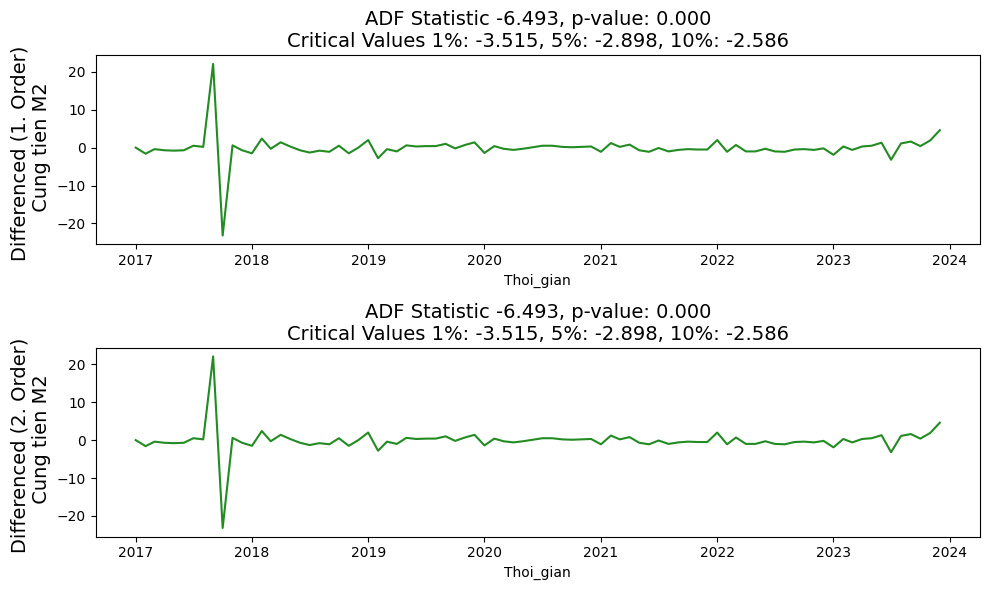

In [410]:
# First Order Differencing
ts_diff = np.diff(data.Cung_tien_M2)
data['Cung_tien_M2_diff_1'] = np.append([0], ts_diff)

# Second Order Differencing
ts_diff = np.diff(data.Cung_tien_M2)
data['Cung_tien_M2_diff_2'] = np.append([0], ts_diff)

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

visualize_adfuller_results(data.Cung_tien_M2_diff_1, 'Differenced (1. Order) \n Cung tien M2', ax[0])
visualize_adfuller_results(data.Cung_tien_M2_diff_2, 'Differenced (2. Order) \n Cung tien M2', ax[1])
plt.tight_layout()
plt.show()

#### Thực hiện lấy sai phân cho feature không có tính dừng : Nhập khẩu lũy kế năm

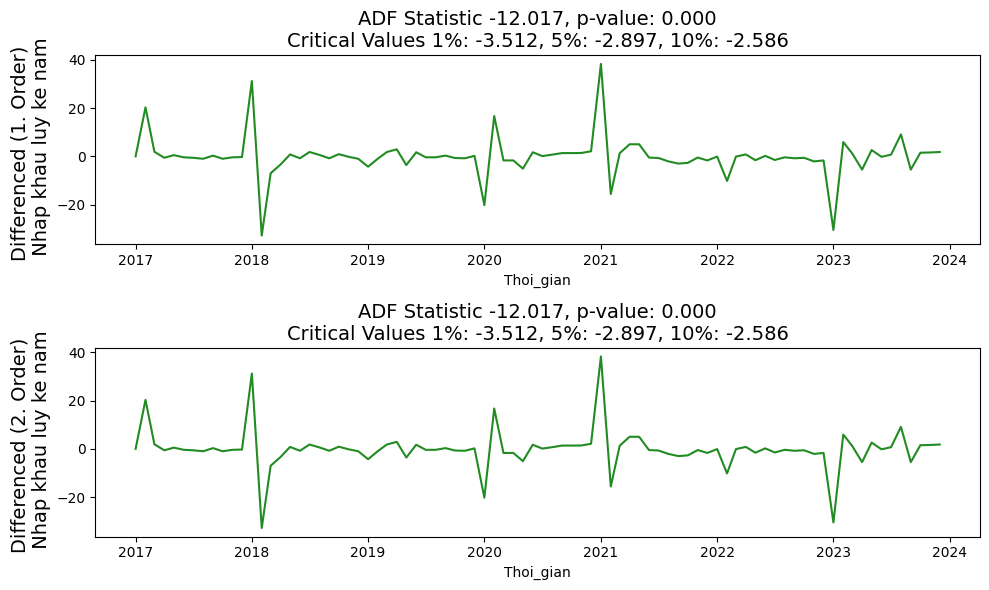

In [411]:
# First Order Differencing
ts_diff = np.diff(data.Nhap_khau_luy_ke_nam)
data['Nhap_khau_luy_ke_nam_diff_1'] = np.append([0], ts_diff)

# Second Order Differencing
ts_diff = np.diff(data.Nhap_khau_luy_ke_nam)
data['Nhap_khau_luy_ke_nam_diff_2'] = np.append([0], ts_diff)

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

visualize_adfuller_results(data.Nhap_khau_luy_ke_nam_diff_1, 'Differenced (1. Order) \n Nhap khau luy ke nam', ax[0])
visualize_adfuller_results(data.Nhap_khau_luy_ke_nam_diff_2, 'Differenced (2. Order) \n Nhap khau luy ke nam', ax[1])
plt.tight_layout()
plt.show()

#### Thực hiện lấy sai phân cho feature không có tính dừng : Xuất khẩu lũy kế năm

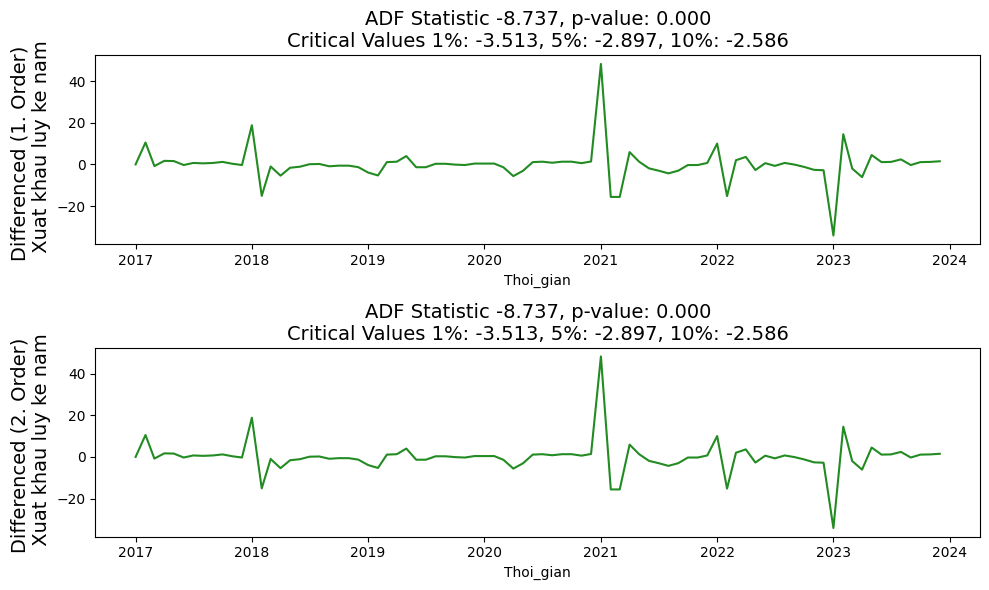

In [412]:
# First Order Differencing
ts_diff = np.diff(data.Xuat_khau_luy_ke_nam)
data['Xuat_khau_luy_ke_nam_diff_1'] = np.append([0], ts_diff)

# Second Order Differencing
ts_diff = np.diff(data.Xuat_khau_luy_ke_nam)
data['Xuat_khau_luy_ke_nam_diff_2'] = np.append([0], ts_diff)

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

visualize_adfuller_results(data.Xuat_khau_luy_ke_nam_diff_1, 'Differenced (1. Order) \n Xuat khau luy ke nam', ax[0])
visualize_adfuller_results(data.Xuat_khau_luy_ke_nam_diff_2, 'Differenced (2. Order) \n Xuat khau luy ke nam', ax[1])
plt.tight_layout()
plt.show()

#### Thực hiện lấy sai phân cho feature không có tính dừng : Tăng trưởng tín dụng

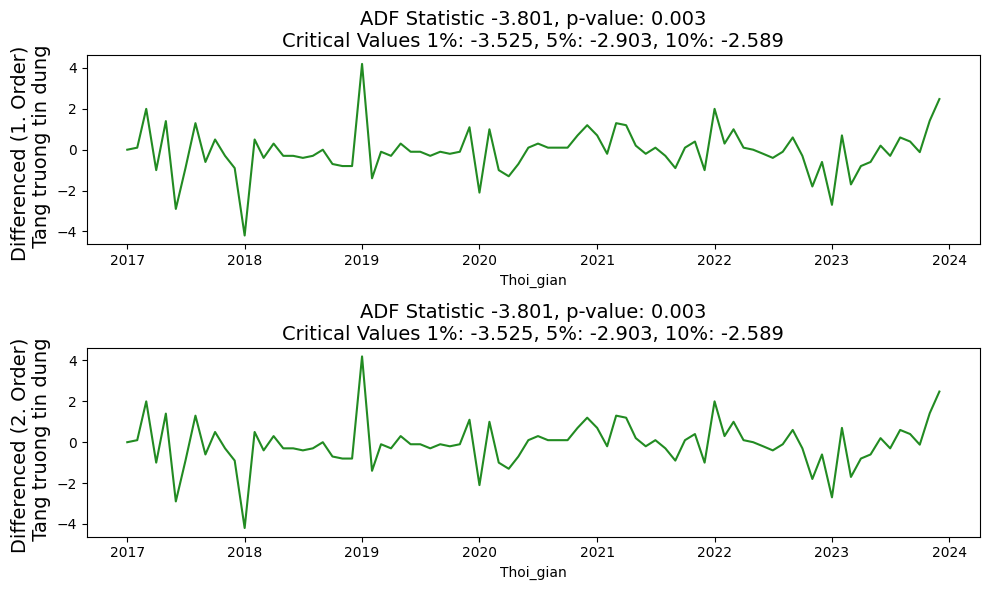

In [413]:
# First Order Differencing
ts_diff = np.diff(data.Tang_truong_tin_dung)
data['Tang_truong_tin_dung_diff_1'] = np.append([0], ts_diff)

# Second Order Differencing
ts_diff = np.diff(data.Tang_truong_tin_dung)
data['Tang_truong_tin_dung_diff_2'] = np.append([0], ts_diff)

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

visualize_adfuller_results(data.Tang_truong_tin_dung_diff_1, 'Differenced (1. Order) \n Tang truong tin dung', ax[0])
visualize_adfuller_results(data.Tang_truong_tin_dung_diff_2, 'Differenced (2. Order) \n Tang truong tin dung', ax[1])
plt.tight_layout()
plt.show()

#### Thêm các columns sau khi lấy sai phân vào table

In [414]:
data.Cung_tien_M2.equals(data.Cung_tien_M2_diff_1.cumsum() + data.Cung_tien_M2.iloc[0])
data.Nhap_khau_luy_ke_nam.equals(data.Nhap_khau_luy_ke_nam_diff_1.cumsum() + data.Nhap_khau_luy_ke_nam.iloc[0])
data.Xuat_khau_luy_ke_nam.equals(data.Xuat_khau_luy_ke_nam_diff_1.cumsum() + data.Xuat_khau_luy_ke_nam.iloc[0])
data.Tang_truong_tin_dung.equals(data.Tang_truong_tin_dung_diff_1.cumsum() + data.Tang_truong_tin_dung.iloc[0])

True

In [415]:
data.columns

Index(['FDI_dang_ki', 'Xuat_khau_luy_ke_nam', 'Nhap_khau_luy_ke_nam',
       'Tang_truong_tin_dung', 'Cung_tien_M2', 'Lam_phat',
       'Tang_truong_GDP_thuc_te', 'Lam_phat_transformed',
       'Cung_tien_M2_diff_1', 'Cung_tien_M2_diff_2',
       'Nhap_khau_luy_ke_nam_diff_1', 'Nhap_khau_luy_ke_nam_diff_2',
       'Xuat_khau_luy_ke_nam_diff_1', 'Xuat_khau_luy_ke_nam_diff_2',
       'Tang_truong_tin_dung_diff_1', 'Tang_truong_tin_dung_diff_2'],
      dtype='object')

## 1.3. Feature Engineering

### 1.3.1. Decomposition

##### The characteristics of a time series are

1. Trend and Level
2. Seasonality
3. Random / Noise   

In [416]:
data.columns

Index(['FDI_dang_ki', 'Xuat_khau_luy_ke_nam', 'Nhap_khau_luy_ke_nam',
       'Tang_truong_tin_dung', 'Cung_tien_M2', 'Lam_phat',
       'Tang_truong_GDP_thuc_te', 'Lam_phat_transformed',
       'Cung_tien_M2_diff_1', 'Cung_tien_M2_diff_2',
       'Nhap_khau_luy_ke_nam_diff_1', 'Nhap_khau_luy_ke_nam_diff_2',
       'Xuat_khau_luy_ke_nam_diff_1', 'Xuat_khau_luy_ke_nam_diff_2',
       'Tang_truong_tin_dung_diff_1', 'Tang_truong_tin_dung_diff_2'],
      dtype='object')

In [417]:
decompose_cols =  ['Tang_truong_GDP_thuc_te', 'FDI_dang_ki', 'Xuat_khau_luy_ke_nam_diff_1', 'Nhap_khau_luy_ke_nam_diff_1',
       'Tang_truong_tin_dung_diff_1', 'Cung_tien_M2_diff_1', 'Lam_phat_transformed']

for col in decompose_cols:
    decomp = seasonal_decompose(data[col], period=12, model='additive', extrapolate_trend='freq')
    data[f"{col}_trend"] = decomp.trend
    data[f"{col}_seasonal"] = decomp.seasonal

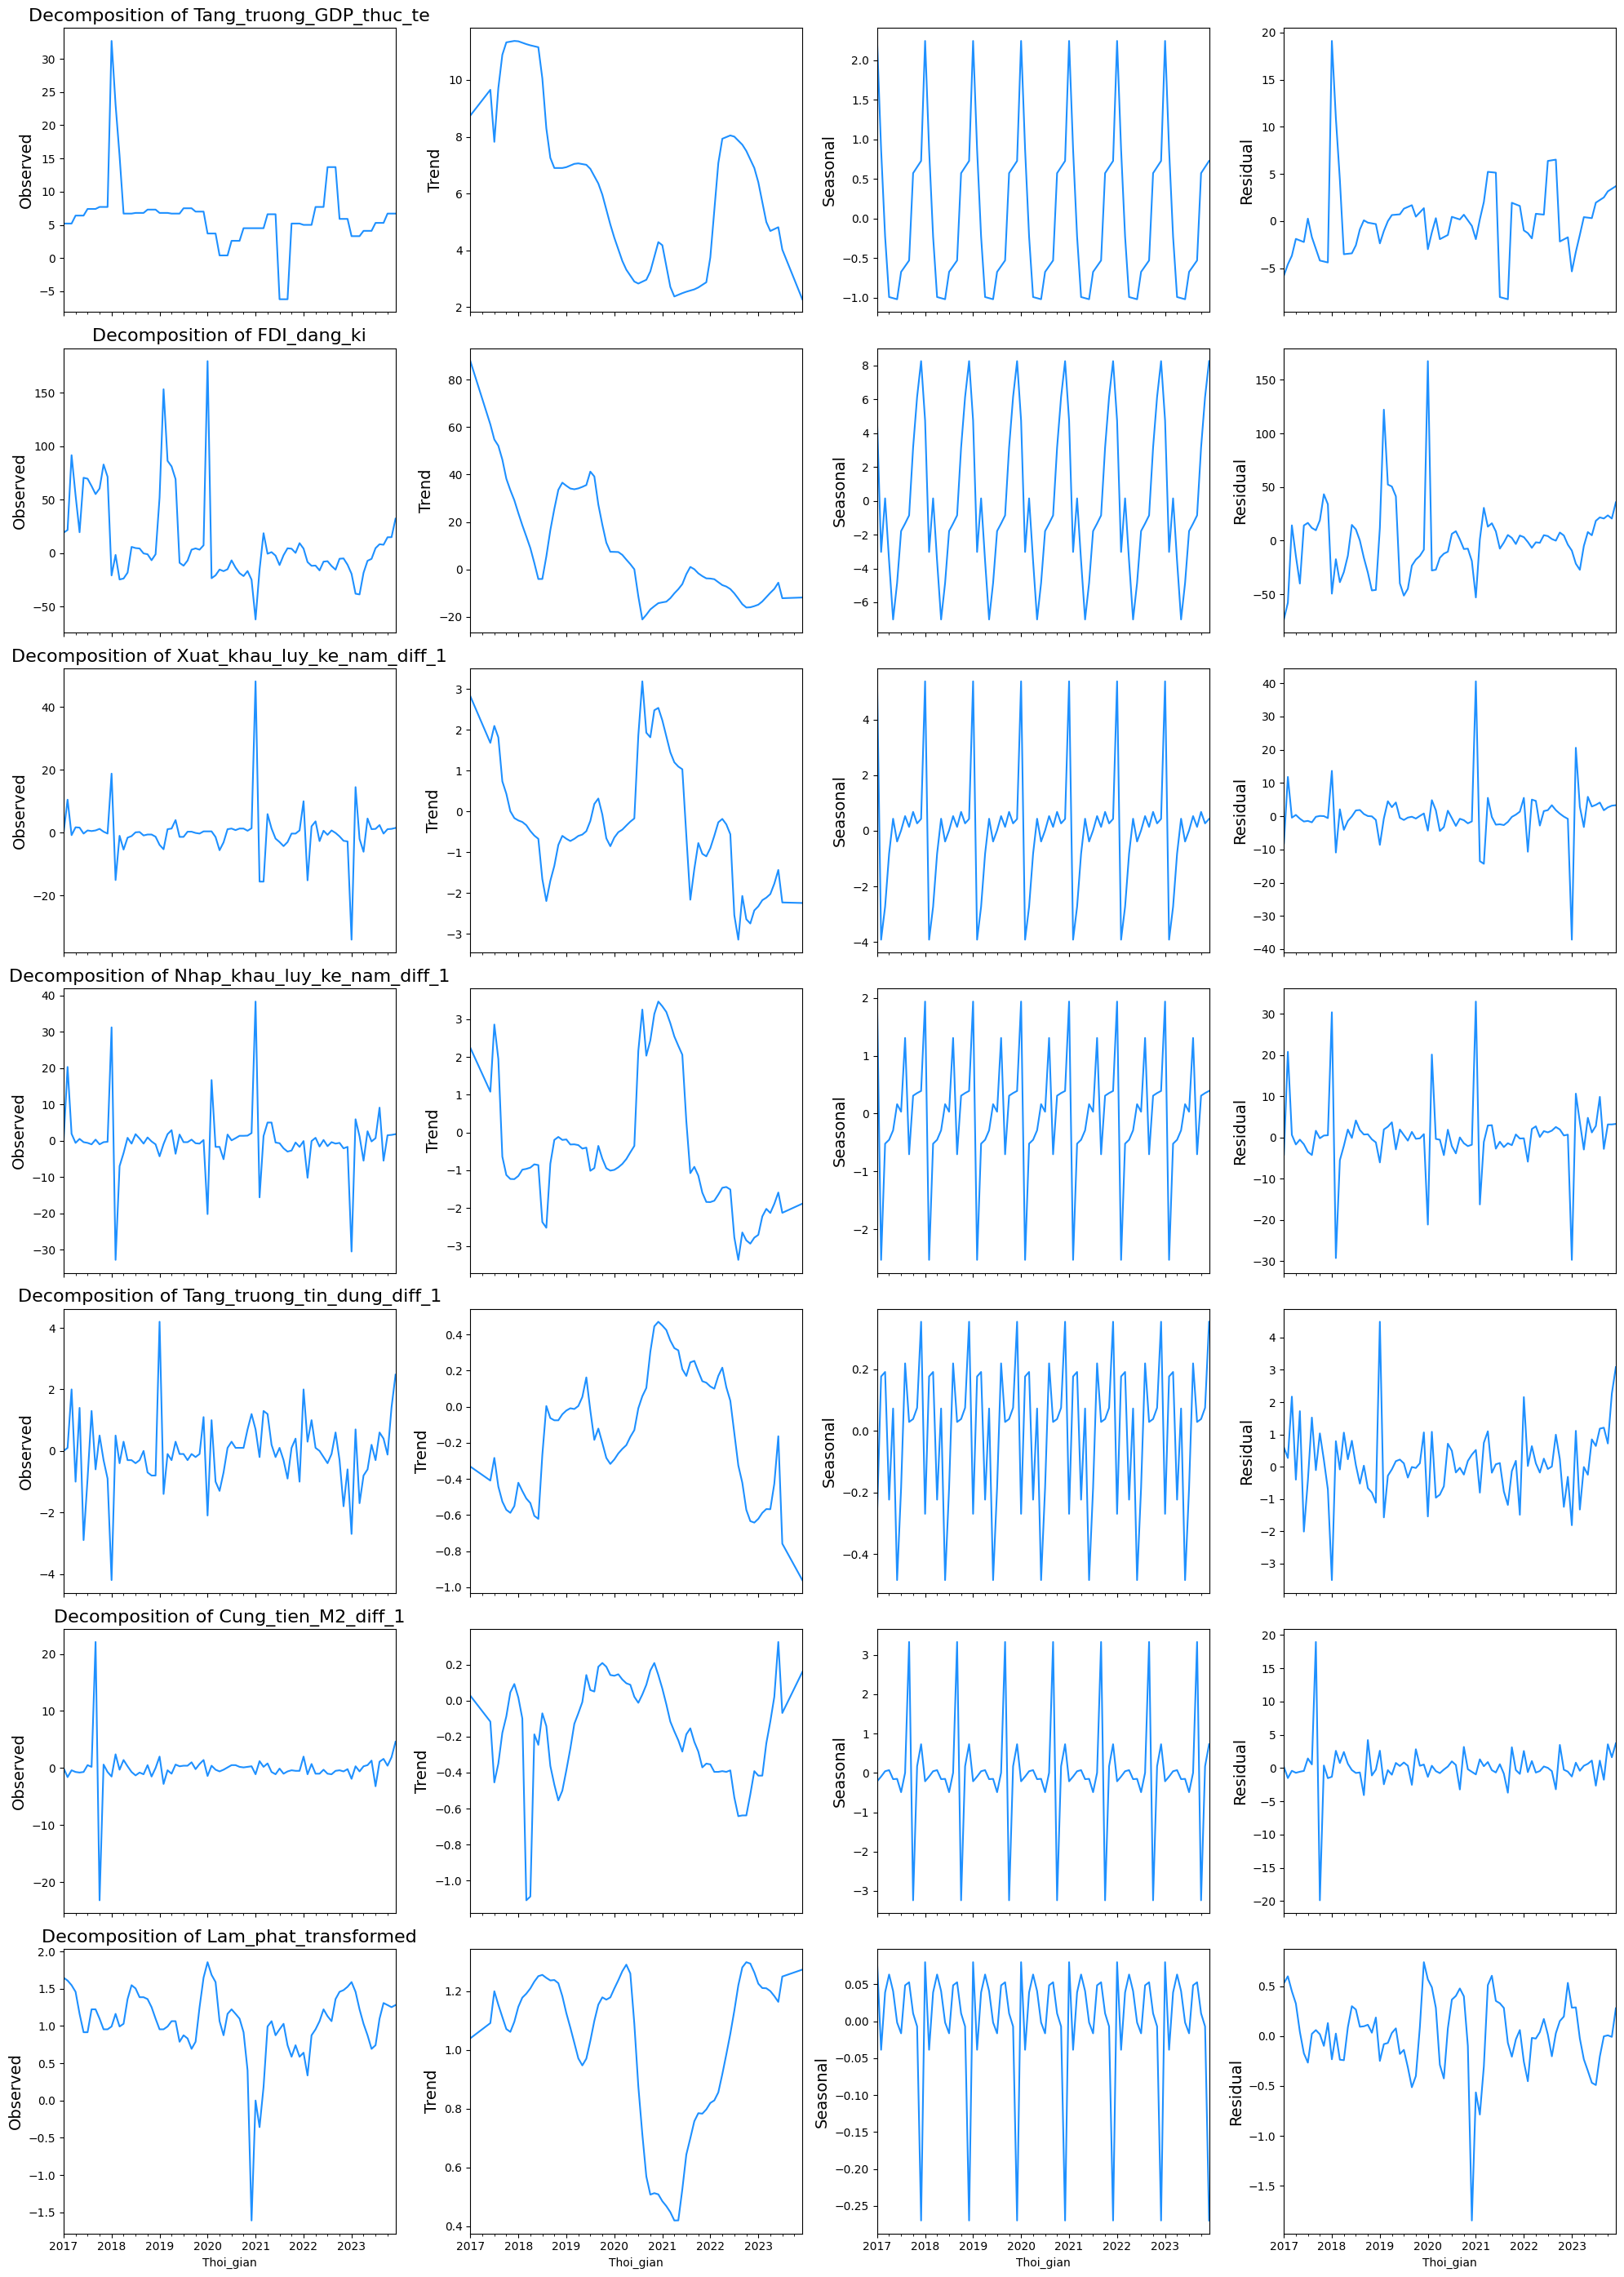

In [418]:
num_rows = len(decompose_cols)
num_cols = 4  # Số cột gồm observed, trend, seasonal và residual

fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows, sharex=True, figsize=(20, 4*num_rows))

for i, col in enumerate(decompose_cols):
    # Decomposition cho mỗi biến
    res = seasonal_decompose(data[col], period=12, model='additive', extrapolate_trend='freq')
    
    # Hiển thị observed
    ax[i, 0].set_title(f'Decomposition of {col}', fontsize=16)
    res.observed.plot(ax=ax[i, 0], legend=False, color='dodgerblue')
    ax[i, 0].set_ylabel('Observed', fontsize=14)

    # Hiển thị trend
    res.trend.plot(ax=ax[i, 1], legend=False, color='dodgerblue')
    ax[i, 1].set_ylabel('Trend', fontsize=14)

    # Hiển thị seasonal
    res.seasonal.plot(ax=ax[i, 2], legend=False, color='dodgerblue')
    ax[i, 2].set_ylabel('Seasonal', fontsize=14)

    # Hiển thị residual
    res.resid.plot(ax=ax[i, 3], legend=False, color='dodgerblue')
    ax[i, 3].set_ylabel('Residual', fontsize=14)

plt.tight_layout()
plt.show()

### 1.3.2. Time featuring

In [419]:
data['year'] = pd.DatetimeIndex(data.index).year
data['month'] = pd.DatetimeIndex(data.index).month
data['quarter'] = pd.DatetimeIndex(data.index).quarter
data[['year', 'month', 'quarter']].tail()

,year,month,quarter
Thoi_gian,,,
2023-08-01,2023,8,3
2023-09-01,2023,9,3
2023-10-01,2023,10,4
2023-11-01,2023,11,4
2023-12-01,2023,12,4


## 1.4. EDA

### 1.4.1. Correlation Matrix

Sự tương quan giữa các column sẽ lớn hơn nếu chúng ta sử dụng time shifted features thay vì các features thông thường

In [420]:
data.columns

Index(['FDI_dang_ki', 'Xuat_khau_luy_ke_nam', 'Nhap_khau_luy_ke_nam',
       'Tang_truong_tin_dung', 'Cung_tien_M2', 'Lam_phat',
       'Tang_truong_GDP_thuc_te', 'Lam_phat_transformed',
       'Cung_tien_M2_diff_1', 'Cung_tien_M2_diff_2',
       'Nhap_khau_luy_ke_nam_diff_1', 'Nhap_khau_luy_ke_nam_diff_2',
       'Xuat_khau_luy_ke_nam_diff_1', 'Xuat_khau_luy_ke_nam_diff_2',
       'Tang_truong_tin_dung_diff_1', 'Tang_truong_tin_dung_diff_2',
       'Tang_truong_GDP_thuc_te_trend', 'Tang_truong_GDP_thuc_te_seasonal',
       'FDI_dang_ki_trend', 'FDI_dang_ki_seasonal',
       'Xuat_khau_luy_ke_nam_diff_1_trend',
       'Xuat_khau_luy_ke_nam_diff_1_seasonal',
       'Nhap_khau_luy_ke_nam_diff_1_trend',
       'Nhap_khau_luy_ke_nam_diff_1_seasonal',
       'Tang_truong_tin_dung_diff_1_trend',
       'Tang_truong_tin_dung_diff_1_seasonal', 'Cung_tien_M2_diff_1_trend',
       'Cung_tien_M2_diff_1_seasonal', 'Lam_phat_transformed_trend',
       'Lam_phat_transformed_seasonal', 'year', 'month

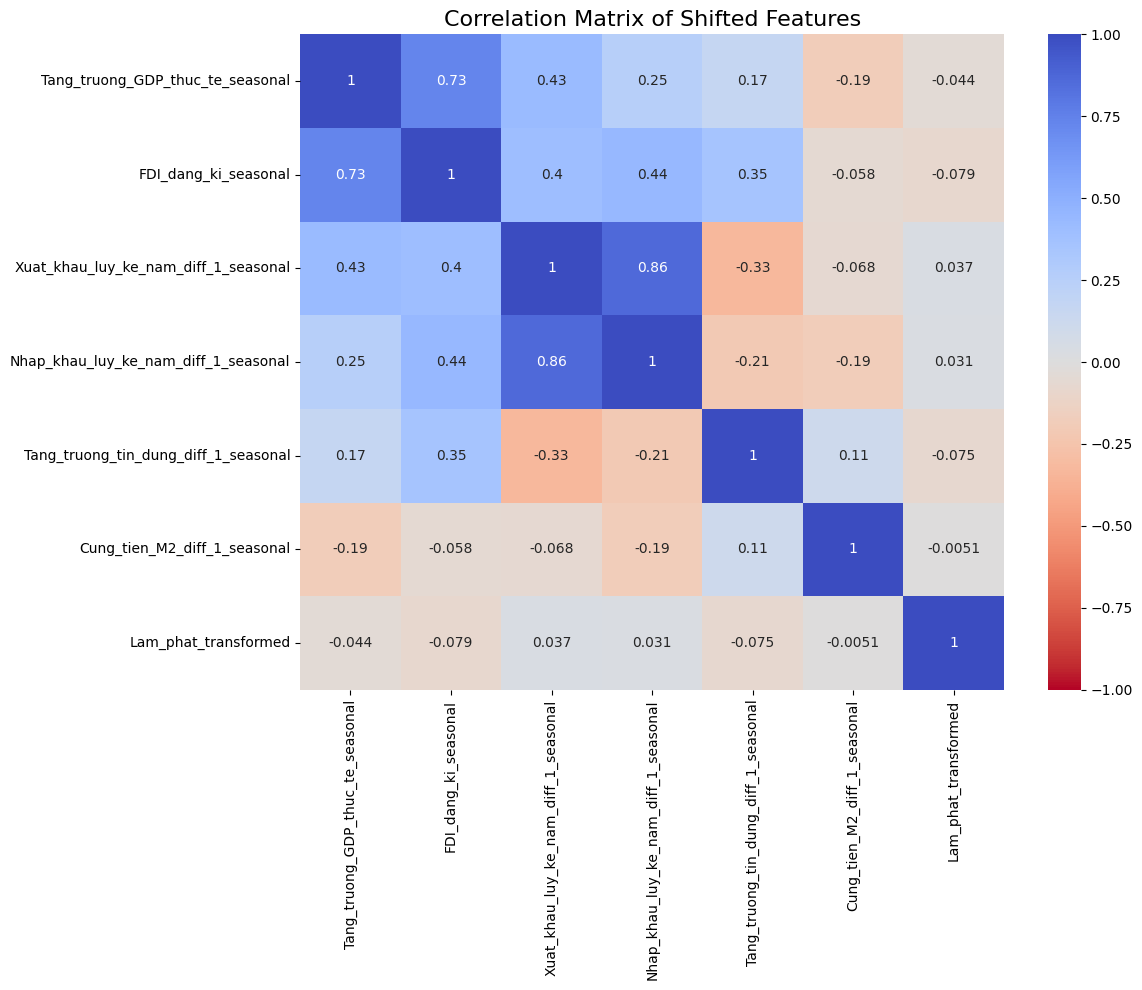

In [421]:
plt.figure(figsize=(12,10))

shifted_cols = ['Tang_truong_GDP_thuc_te_seasonal', 'FDI_dang_ki_seasonal', 'Xuat_khau_luy_ke_nam_diff_1_seasonal', 'Nhap_khau_luy_ke_nam_diff_1_seasonal',
       'Tang_truong_tin_dung_diff_1_seasonal', 'Cung_tien_M2_diff_1_seasonal', 'Lam_phat_transformed']
corrmat = data[shifted_cols].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r')
plt.title('Correlation Matrix of Shifted Features', fontsize=16)

plt.tight_layout()
plt.show()

Nhận thấy, ngoại trừ FDI_dang_ki và Tang_truong_GDP_thuc_te (target variable), không có sự tương quan nào quá lớn

##

### 1.4.2. Auto correlation

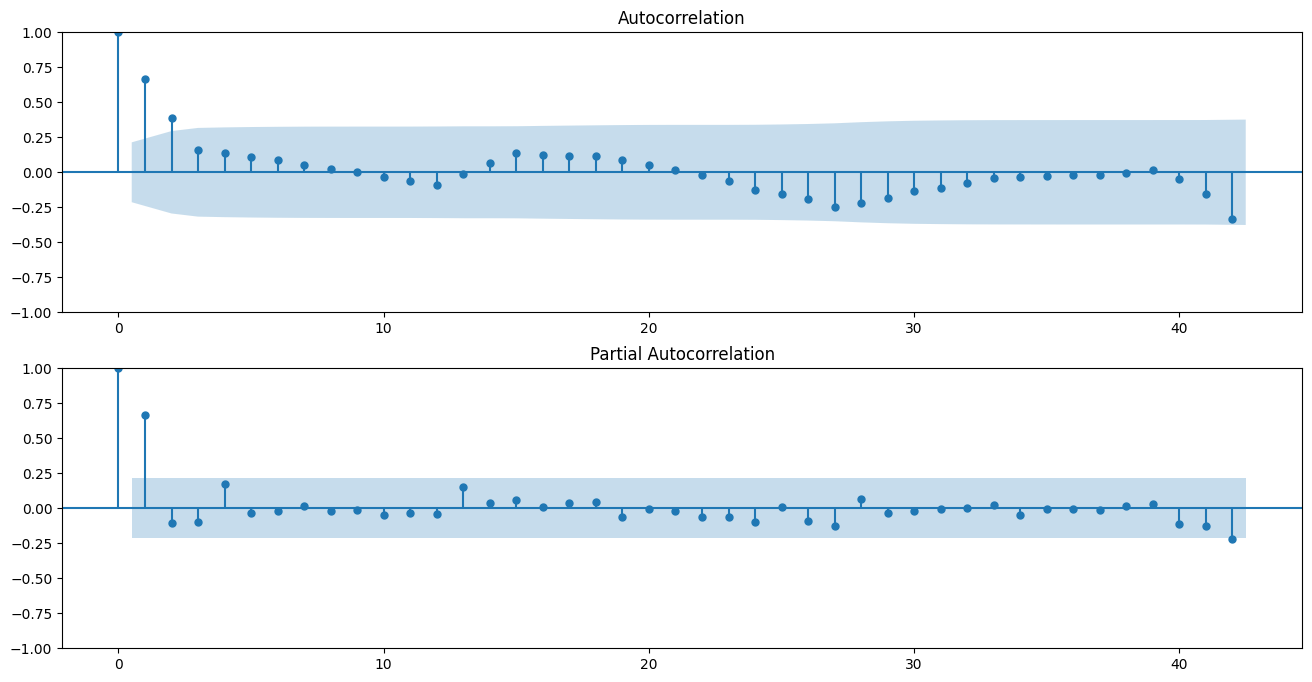

In [422]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(data.Tang_truong_GDP_thuc_te,lags=42, ax=ax[0])
plot_pacf(data.Tang_truong_GDP_thuc_te,lags=42, ax=ax[1])
plt.show()

## 1.5. Cross validation

Thiết lập các bước cần thiết để chia dữ liệu chuỗi thời gian thành 3 phân đoạn không trùng lặp, giữ nguyên thứ tự thời gian. X chứa các chỉ số thời gian, còn y chứa dữ liệu mục tiêu là tốc độ tăng trưởng GDP thực tế. 

In [423]:
N_SPLITS = 3

X = data.index
y = data.Tang_truong_GDP_thuc_te

folds = TimeSeriesSplit(n_splits=N_SPLITS)

In [424]:
X.shape

(84,)

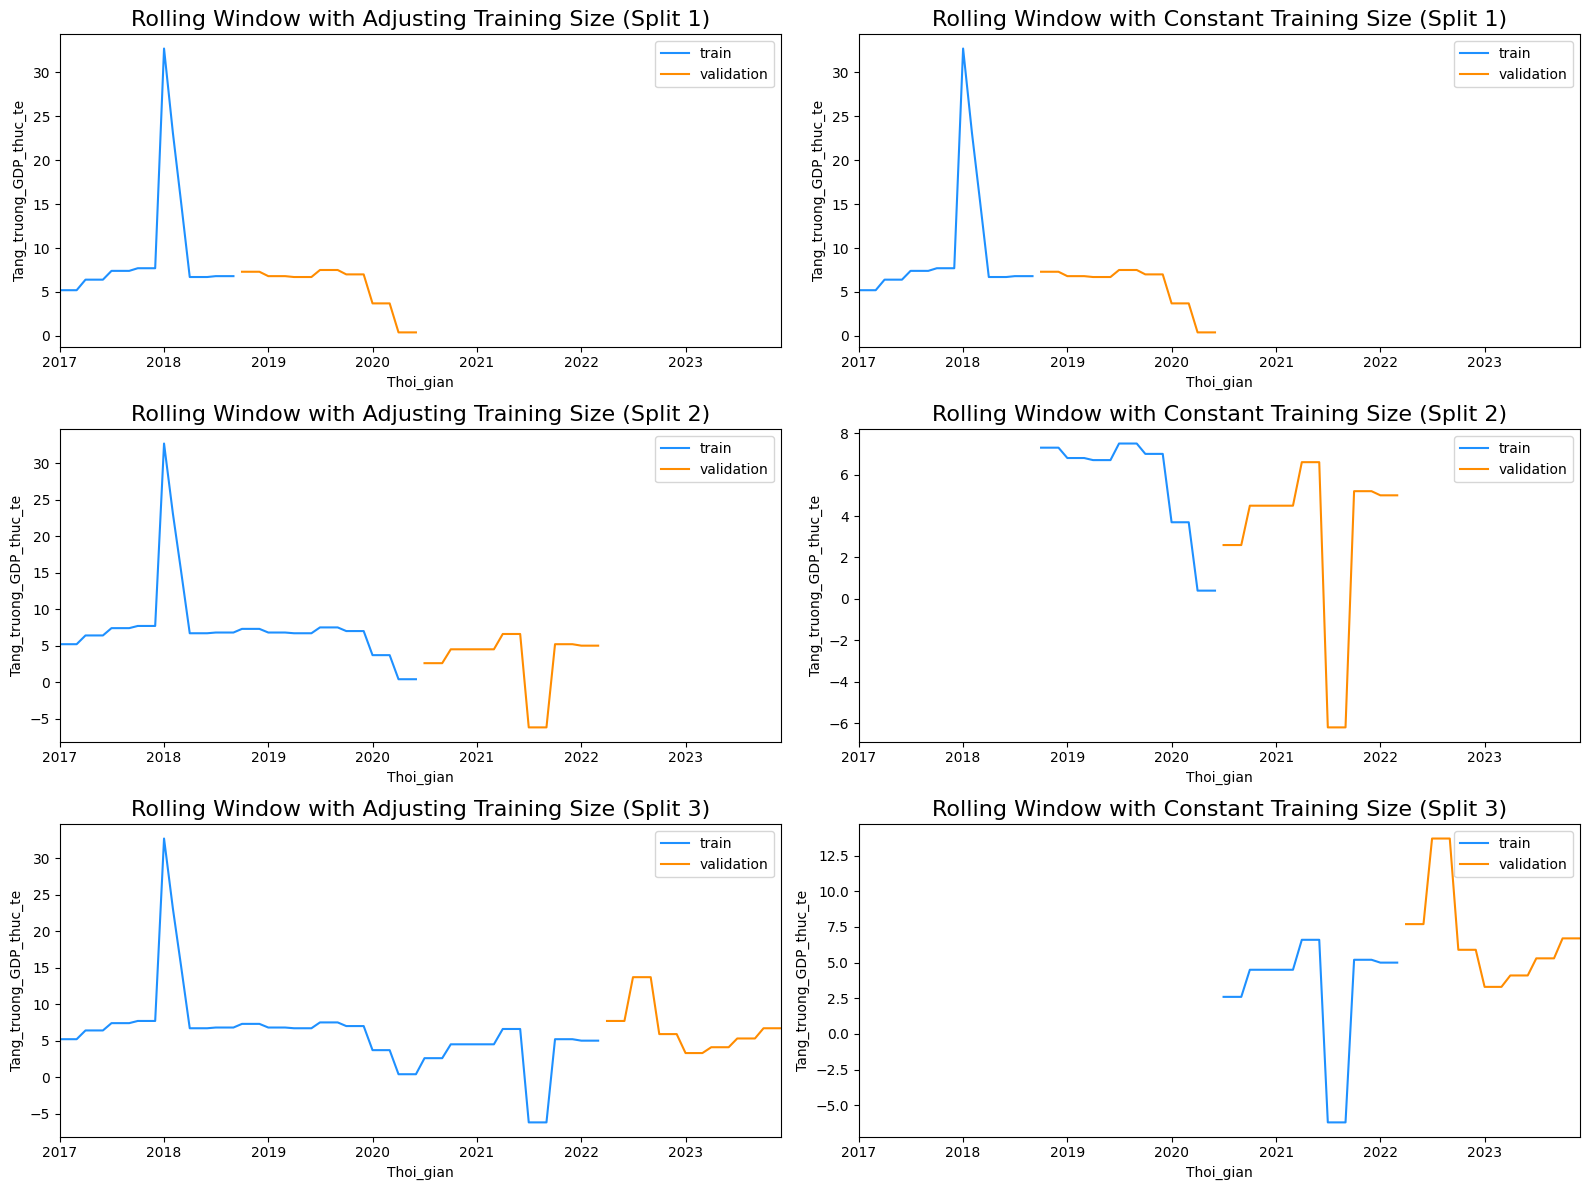

In [425]:
f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(16,12))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    sns.lineplot(x= X_train, y= y_train, ax=ax[i,0], color='dodgerblue', label='train')
    sns.lineplot(x= X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
                 y= y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
                 ax=ax[i,1], color='dodgerblue', label='train')

    for j in range(2):
        sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='darkorange', label='validation')
    ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)

for i in range(N_SPLITS):
    ax[i, 0].set_xlim([date(2017, 1, 1), date(2023, 12, 1)])
    ax[i, 1].set_xlim([date(2017, 1, 1), date(2023, 12, 1)])
plt.tight_layout()
plt.show()

## 1.6. Model

Chuẩn bị dữ liệu để huấn luyện mô hình dự báo GDP thực tế và kiểm tra hiệu quả của mô hình trên một quý cụ thể sau giai đoạn huấn luyện.

In [426]:
data['quarter_idx'] = (data.quarter != data.quarter.shift(1)).cumsum()

target = 'Tang_truong_GDP_thuc_te'
features = [feature for feature in data.columns if feature != target]

N_SPLITS = 18
# 2017 - 6/2021: 18 quý

X = data[data.quarter_idx < N_SPLITS][features]
y = data[data.quarter_idx < N_SPLITS][target]

X_test = data[data.quarter_idx >= N_SPLITS][features]
y_test = data[data.quarter_idx >= N_SPLITS][target]

In [427]:
X_test.shape

(33, 33)

In [428]:
X.tail()

,FDI_dang_ki,Xuat_khau_luy_ke_nam,Nhap_khau_luy_ke_nam,Tang_truong_tin_dung,Cung_tien_M2,Lam_phat,Lam_phat_transformed,Cung_tien_M2_diff_1,Cung_tien_M2_diff_2,Nhap_khau_luy_ke_nam_diff_1,...,Tang_truong_tin_dung_diff_1_trend,Tang_truong_tin_dung_diff_1_seasonal,Cung_tien_M2_diff_1_trend,Cung_tien_M2_diff_1_seasonal,Lam_phat_transformed_trend,Lam_phat_transformed_seasonal,year,month,quarter,quarter_idx
Thoi_gian,,,,,,,,,,,,,,,,,,,,,
2020-11-01,-16.9,5.5,1.6,11.0,14.2,1.5,0.405465,0.2,0.2,1.4,...,0.445833,0.075364,0.208333,0.169561,0.512500,-0.007166,2020,11,4,16
2020-12-01,-25.0,6.9,3.7,12.2,14.5,0.2,-1.609438,0.3,0.3,2.1,...,0.470833,0.354575,0.141667,0.729136,0.508398,-0.269752,2020,12,4,16
2021-01-01,-62.2,55.1,42.0,12.9,13.4,-1.0,0.000000,-1.1,-1.1,38.3,...,0.450000,-0.268685,0.066667,-0.213379,0.485234,0.079794,2021,1,1,17
2021-02-01,-15.6,39.5,26.4,12.7,14.6,0.7,-0.356675,1.2,1.2,-15.6,...,0.425000,0.176979,-0.020833,-0.092606,0.468492,-0.038744,2021,2,1,17
2021-03-01,18.5,23.9,27.7,14.0,14.8,1.2,0.182322,0.2,0.2,1.3,...,0.366667,0.191692,-0.116667,0.042452,0.448067,0.038871,2021,3,1,17


Biểu đồ trên hiển thị dữ liệu huấn luyện và kiểm tra GDP thực tế theo thời gian.    
Biểu đồ dưới hiển thị chỉ số quý (quarter_idx) theo thời gian. 

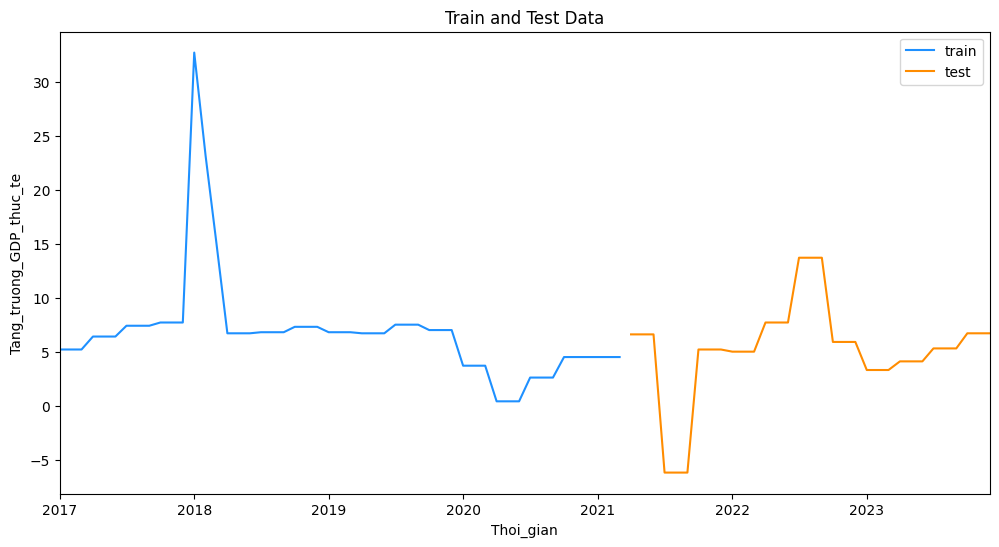

In [429]:
folds = np.linspace(0, N_SPLITS-3, num=N_SPLITS-2)
plt.figure(figsize=(12, 6))
sns.lineplot(x=X.index, y=y, color='dodgerblue', label='train')
sns.lineplot(x=X_test.index, y=y_test, color='darkorange', label='test')

plt.xlim([date(2017, 1, 1), date(2023, 12, 1)])

plt.legend()
plt.title('Train and Test Data')

plt.show()

In [430]:
def plot_approach_evaluation(y_pred, y_valid_pred, score_mae, score_rsme, approach_name):
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    f.suptitle(approach_name, fontsize=16)
    sns.lineplot(x=X.index, y=y, ax=ax[0], color='dodgerblue', label='Training', linewidth=2)
    sns.lineplot(x=X_test.index, y=y_test, ax=ax[0], color='gold', label='Ground Truth', linewidth=2)
    sns.lineplot(x=X_test.index, y=y_pred, ax=ax[0], color='darkorange', label='Predicted', linewidth=2)
    ax[0].set_xlim([date(2017, 1, 1), date(2023, 12, 1)])
    ax[0].set_ylim([-30, 30])
    ax[0].set_title(f'Prediction \n MAE: {mean_absolute_error(y_test, y_pred):.2f}, RSME: {math.sqrt(mean_squared_error(y_valid, y_valid_pred)):.2f}', fontsize=14)
    ax[0].set_xlabel(xlabel='Date', fontsize=14)
    ax[0].set_ylabel(ylabel='Tang truong GDP thuc te', fontsize=14)

    sns.lineplot(x=folds, y=score_mae,  color='gold', label='MAE', ax=ax[1])
    sns.lineplot(x=folds, y=score_rsme, color='indianred', label='RSME', ax=ax[1])
    ax[1].set_title('Loss', fontsize=14)
    ax[1].set_xlabel(xlabel='Fold', fontsize=14)
    ax[1].set_ylabel(ylabel='Loss', fontsize=14)
    ax[1].set_ylim([0, 30])   
    plt.show()

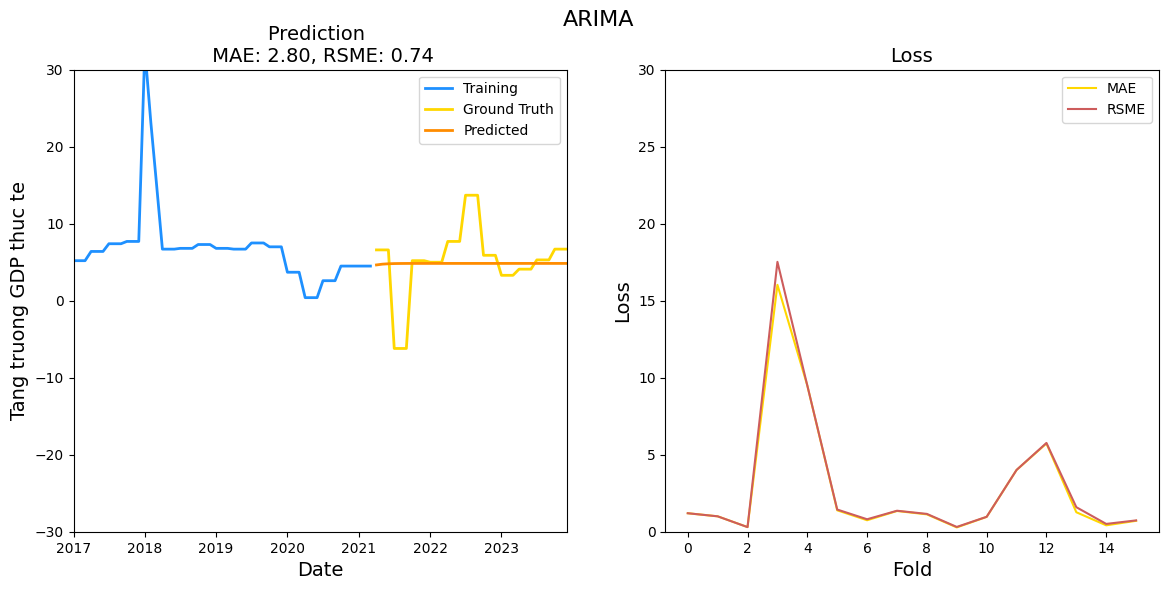

In [431]:
score_mae = []
score_rmse = []

for fold, valid_quarter_id in enumerate(range(2, N_SPLITS)):
    train_index = data[data.quarter_idx < valid_quarter_id].index
    valid_index = data[data.quarter_idx == valid_quarter_id].index

    train_iloc = [data.index.get_loc(idx) for idx in train_index]
    valid_iloc = [data.index.get_loc(idx) for idx in valid_index]

    y_train, y_valid = y.iloc[train_iloc], y.iloc[valid_iloc]

    model = ARIMA(y_train, order=(1, 1, 1))
    model_fit = model.fit()

    y_valid_pred = model_fit.predict(start=valid_index[0], end=valid_index[-1])
    
    score_mae.append(mean_absolute_error(y_valid, y_valid_pred))
    score_rmse.append(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))

# Fit ARIMA model on the entire dataset
model = ARIMA(y, order=(2, 1, 1))
model_fit = model.fit()

start_index = y.index[-1] + pd.DateOffset(months=1)
end_index = start_index + pd.DateOffset(months=len(y_test) - 1)

y_pred = model_fit.predict(start=start_index, end=end_index).reset_index(drop=True)

plot_approach_evaluation(y_pred, y_valid_pred, score_mae, score_rmse, 'ARIMA')


ValueError: All arrays must be of the same length

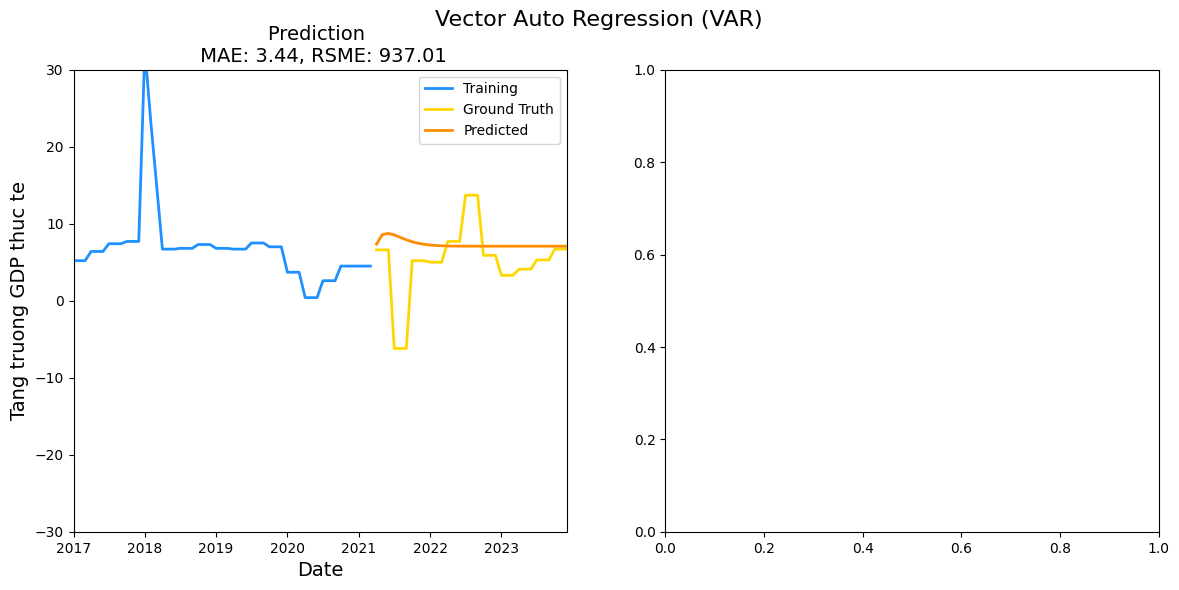

In [434]:
score_mae = []
score_rsme = []

features = ['FDI_dang_ki', 'Xuat_khau_luy_ke_nam_diff_1', 'Nhap_khau_luy_ke_nam_diff_1',
       'Tang_truong_tin_dung_diff_1', 'Cung_tien_M2_diff_1', 'Lam_phat_transformed']

for fold, valid_quarter_id in enumerate(range(2, N_SPLITS)):
    # Get indices for this fold
    train_index = data[data.quarter_idx < valid_quarter_id].index
    valid_index = data[data.quarter_idx == valid_quarter_id].index
    
    # Convert indices to iloc positions
    train_iloc = [data.index.get_loc(idx) for idx in train_index]
    valid_iloc = [data.index.get_loc(idx) for idx in valid_index]

    # Prepare training and validation data for this fold
    X_train, X_valid = X.iloc[train_iloc][features], X.iloc[valid_iloc][features]
    y_train, y_valid = y.iloc[train_iloc], y.iloc[valid_iloc]
    
    # Fit model with Vector Auto Regression (VAR)
    model = VAR(pd.concat([y_train, X_train], axis=1))
    model_fit = model.fit()
    
    # Prediction with Vector Auto Regression (VAR)
    y_valid_pred = model_fit.forecast(model_fit.endog, steps=len(X_valid))
    y_valid_pred = pd.Series(y_valid_pred[:, 0])

    # Calcuate metrics
    score_mae.append(mean_absolute_error(y_valid, y_valid_pred))
    score_rsme.append(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))

# Fit model with Vector Auto Regression (VAR)
model = VAR(pd.concat([y, X[features]], axis=1))
model_fit = model.fit()

# Prediction with Vector Auto Regression (VAR)
y_pred = model_fit.forecast(model_fit.endog, steps=len(X_test))
y_pred = pd.Series(y_pred[:, 0])

plot_approach_evaluation(y_pred, y_valid_pred, score_mae, score_rsme, 'Vector Auto Regression (VAR)')